# MANUAL DATA COLLECTION

In [1]:
#%matplotlib inline
%matplotlib widget

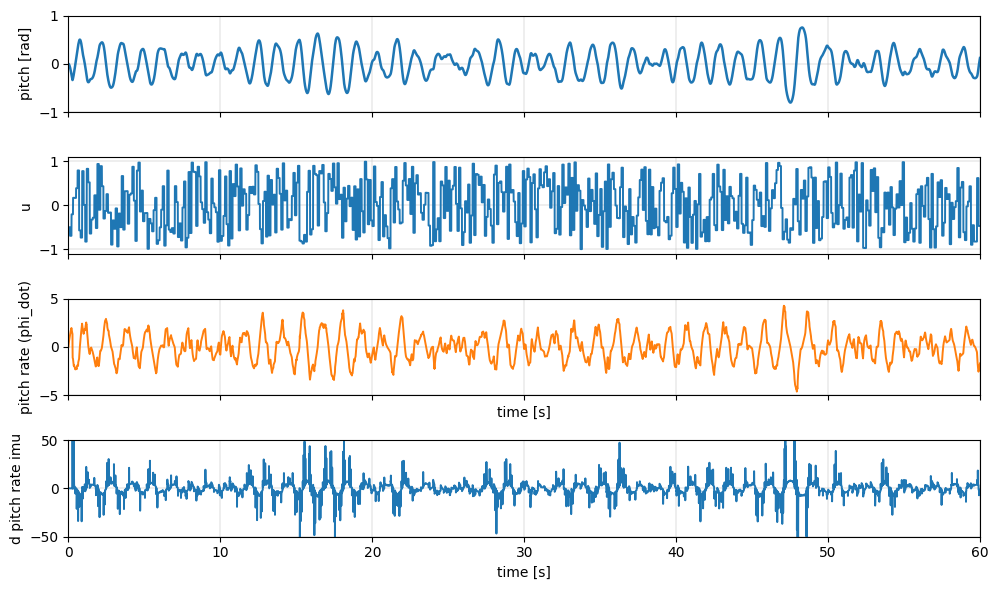

Done. Samples: 60001  Sim time: 60.001s


In [2]:
# MuJoCo viewer (real-time paced) + live 3-row plot (pitch [rad], action, pitch rate [rad/s])

import time, math, numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import mujoco as mj
import mujoco.viewer as viewer

# -------- config --------
CTRL_DT   = 0.1          # control update period (sim seconds)
DURATION  = 60.0          # total run time (sim seconds)
U_MIN, U_MAX = -1.0, 1.0  # throttle bounds
RTF      = 1.0            # realtime factor: 1.0=real-time, 0.5=half-speed, 2.0=2x
REFRESH_HZ = 6            # plot refresh rate (wall-clock)

# XML path

MODEL_XML = "monstertruck.xml"

# -------- quat -> RPY (ZYX), radians --------
def quat_to_rpy_rad(qw, qx, qy, qz):
    R00 = 1 - 2*(qy*qy + qz*qz)
    R10 = 2*(qx*qy + qw*qz)
    R20 = 2*(qx*qz - qw*qy)
    R21 = 2*(qy*qz + qw*qx)
    R22 = 1 - 2*(qx*qx + qy*qy)
    yaw   = math.atan2(R10, R00)
    pitch = -math.asin(max(-1.0, min(1.0, R20)))
    roll  = math.atan2(R21, R22)
    return roll, pitch, yaw

def angdiff(a, b):
    """Return wrapped difference a-b in (-pi, pi]."""
    return ((a - b + math.pi) % (2.0*math.pi)) - math.pi



import numpy as np
from scipy.signal import butter, filtfilt
def lowpass_filter_acc(acc, dt, cutoff_hz=5.0, order=2):
    acc = np.asarray(acc, dtype=float)

    # Sampling frequency
    fs = 1.0 / dt

    # Normalized cutoff frequency (Nyquist)
    wn = cutoff_hz / (fs / 2.0)
    wn = min(max(wn, 1e-6), 0.999999)  # clamp to (0, 1) to avoid errors

    # Design Butterworth low-pass filter
    b, a = butter(order, wn, btype='low')

    # Apply zero-phase filtering
    acc_filt = filtfilt(b, a, acc)

    return acc_filt



# -------- model --------
m = mj.MjModel.from_xml_path(MODEL_XML)
#d = mj.MjData(m)
data = mj.MjData(m)
mj.mj_resetData(m, data); mj.mj_forward(m, data)
data.ctrl[:] = 0.0

sim_dt        = float(m.opt.timestep)
steps_per_cmd = max(1, int(round(CTRL_DT / sim_dt)))
free_j = next(j for j in range(m.njnt) if m.jnt_type[j] == mj.mjtJoint.mjJNT_FREE)
qadr   = m.jnt_qposadr[free_j] + 3  # qw,qx,qy,qz start

# --- IMU gyro sensor (for pitch rate) ---
gyro_id = mj.mj_name2id(m, mj.mjtObj.mjOBJ_SENSOR, "imu_gyro")
if gyro_id < 0:
    raise RuntimeError("imu_gyro sensor not found in model XML")
gyro_adr = m.sensor_adr[gyro_id]  # start index in data.sensordata


# --- IMU acc sensor (for pitch rate) ---
acc_id = mj.mj_name2id(m, mj.mjtObj.mjOBJ_SENSOR, "imu_acc")
if acc_id < 0:
    raise RuntimeError("acc_id sensor not found in model XML")
acc_adr = m.sensor_adr[acc_id]  # start index in data.sensordata


# -------- live plot setup --------
plt.ioff()  # we'll redraw manually via clear_output
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

(line_pitch,)       = ax1.plot([], [], lw=1.8)
(line_u,)           = ax2.plot([], [], lw=1.4)
(line_rate,)        = ax3.plot([], [], lw=1.4)
(line_rate_imu,)    = ax3.plot([], [], lw=1.4)
(line_drate_imu,)    = ax4.plot([], [], lw=1.4)

ax1.set_ylabel("pitch [rad]")
ax1.set_ylim(-1, 1)
ax1.grid(True, linewidth=0.3)

ax2.set_ylabel("u")
ax2.set_ylim(-1.1, 1.1)
ax2.grid(True, linewidth=0.3)

ax3.set_ylabel("pitch rate (phi_dot)")
ax3.set_xlabel("time [s]")
ax3.set_ylim(-5.0, 5.0)   # adjust if you see clipping
ax3.grid(True, linewidth=0.3)

ax4.set_ylabel("d pitch rate imu")
ax4.set_xlabel("time [s]")
ax4.set_ylim(-50.0, 50.0)   # adjust if you see clipping
ax4.grid(True, linewidth=0.3)

fig.tight_layout()
display(fig)

rate_imu_1= 0.0


# -------- run viewer --------
t_log, pitch_log, u_log, rate_log, rate_imu_log, drate_imu_log = [], [], [], [], [], []
last_refresh_wall = time.perf_counter()

with viewer.launch_passive(m, data) as v:
    t0_sim   = data.time
    t0_wall  = time.perf_counter()
    next_cmd = t0_sim
    u = 0.0

    prev_pitch = None

    while data.time - t0_sim < DURATION:
        # choose a new random throttle every CTRL_DT (sim time)
        if data.time >= next_cmd:
            u = float(np.random.uniform(U_MIN, U_MAX))
            data.ctrl[:] = u
            next_cmd += CTRL_DT

        # one physics tick
        mj.mj_step(m, data)

        # read pitch and compute pitch rate (wrapped finite diff over sim_dt)
        qw, qx, qy, qz = data.qpos[qadr:qadr+4]
        _, pitch, _ = quat_to_rpy_rad(qw, qx, qy, qz)

        if prev_pitch is None:
            rate = 0.0
        else:
            rate = (pitch - prev_pitch) #angdiff(pitch, prev_pitch) / sim_dt
        prev_pitch = pitch

        ## CALCULATE SPEED FROM IMU
        # imu_gyro is angular velocity in IMU local frame: [wx, wy, wz] (rad/s)
        gyro = data.sensordata[gyro_adr : gyro_adr + 3]
        rate_imu = float(gyro[1])

        # imu_gyro is angular velocity in IMU local frame: [acc_x, acc_y, acc_z] (rad/s)
        acc = data.sensordata[acc_adr : acc_adr + 3]
        acc_imu = float(acc[0])

        ## CALCULATE ACCELERATION
        dd_rate_imu = (rate_imu - rate_imu_1)/sim_dt
        rate_imu_1 = rate_imu

        t_rel = data.time - t0_sim
        
        t_log.append(t_rel)
        pitch_log.append(pitch)
        u_log.append(u)
        rate_log.append(rate)
        rate_imu_log.append(rate_imu)
        drate_imu_log.append(acc_imu)

        # live-plot at REFRESH_HZ (wall time)
        now = time.perf_counter()
        if now - last_refresh_wall >= 1.0 / REFRESH_HZ:
            line_pitch.set_data(t_log, pitch_log)
            line_u.set_data(t_log, u_log)
            #line_rate.set_data(t_log, rate_log)
            line_rate_imu.set_data(t_log, rate_imu_log)
            line_drate_imu.set_data(t_log, drate_imu_log)
            ax1.set_xlim(0.0, max(5.0, t_rel))
            clear_output(wait=True)
            display(fig)
            last_refresh_wall = now

        # real-time pacing
        sim_elapsed  = data.time - t0_sim
        target_wall  = t0_wall + sim_elapsed / max(1e-9, RTF)
        sleep_needed = target_wall - time.perf_counter()
        if sleep_needed > 0:
            time.sleep(min(sleep_needed, 0.01))

        v.sync()

# final draw
line_pitch.set_data(t_log, pitch_log)
line_u.set_data(t_log, u_log)
#line_rate.set_data(t_log, rate_log)
line_rate_imu.set_data(t_log, rate_imu_log)
line_drate_imu.set_data(t_log, drate_imu_log)
ax1.set_xlim(0.0, max(5.0, t_log[-1] if t_log else 5.0))
clear_output(wait=True)
display(fig)

print(f"Done. Samples: {len(t_log)}  Sim time: {t_log[-1]:.3f}s")


# GAUSSIAN PROCESS DYNAMICS

In [3]:
import torch
import gpytorch
import numpy as np

# ============================================================
# ---- Base Exact GP model -----------------------------------
# ============================================================

device = torch.device("cuda")

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel='RBF', ard_dims=None):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        # Choose kernel type
        if kernel == 'RBF':
            base_kernel = gpytorch.kernels.RBFKernel(ard_num_dims=ard_dims)
        elif kernel == 'Matern':
            base_kernel = gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=ard_dims)
        elif kernel == 'RQ':
            base_kernel = gpytorch.kernels.RQKernel(ard_num_dims=ard_dims)
        else:
            raise ValueError(f"Unsupported kernel type: {kernel}")

        self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# ============================================================
# ---- Individual GP Manager: data + normalization -----------
# ============================================================

class GPManager:
    def __init__(self, kernel='RBF', lr=0.03, iters=300, device=device):
        self.kernel = kernel
        self.lr = lr
        self.iters = iters
        self.device = device

        self.trained = False
        self.X_train = None
        self.Y_train = None

        self.likelihood = None
        self.model = None

    # ----------------------------- #
    #        FIT / INITIAL TRAIN    #
    # ----------------------------- #
    def fit(self, X, Y):
        X = torch.tensor(X, dtype=torch.float32, device=self.device)
        Y = torch.tensor(Y, dtype=torch.float32, device=self.device)

        self.X_train = X.clone()
        self.Y_train = Y.clone()

        self.retrain()

    def retrain(self):
        self._compute_normalization()
        self._train_model()

    # ----------------------------- #
    #       ADD NEW DATA POINTS     #
    # ----------------------------- #
    def add_data(self, X_new, Y_new, retrain=True):
        """
        Add new data (single or batch) to GP training set.
        Optionally retrain the model.
        """
        X_new = torch.tensor(X_new, dtype=torch.float32, device=self.device)
        Y_new = torch.tensor(Y_new, dtype=torch.float32, device=self.device).flatten()

        if self.Y_train.ndim > 1:
            self.Y_train = self.Y_train.flatten()

        self.X_train = torch.cat([self.X_train, X_new], dim=0)
        self.Y_train = torch.cat([self.Y_train, Y_new], dim=0)

        if retrain:
            self.retrain()

    # ----------------------------- #
    #         INTERNAL UTILS        #
    # ----------------------------- #
    def _compute_normalization(self):
        self.X_mean = self.X_train.mean(0)
        self.X_std  = self.X_train.std(0)
        self.Y_mean = self.Y_train.mean()
        self.Y_std  = self.Y_train.std()

        # avoid division by zero
        self.X_std = torch.where(self.X_std == 0.0, torch.ones_like(self.X_std), self.X_std)
        if self.Y_std == 0.0:
            self.Y_std = torch.tensor(1.0, device=self.device)

        self.Xn = (self.X_train - self.X_mean) / self.X_std
        self.Yn = (self.Y_train - self.Y_mean) / self.Y_std

    def dataset(self):
        X_train = self.X_train.detach().cpu().numpy()
        Y_train = self.Y_train.detach().cpu().numpy()
        return X_train, Y_train

    def _train_model(self):
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood().to(self.device)
        self.likelihood.noise_covar.initialize(noise=1e-3)

        self.model = ExactGPModel(
            self.Xn, self.Yn, self.likelihood,
            kernel=self.kernel,
            ard_dims=self.X_train.shape[-1]
        ).to(self.device)

        self.train_gp(self.model, self.likelihood, self.Xn, self.Yn)
        self.trained = True

    def train_gp(self, model, likelihood, x, y):
        model.train(); likelihood.train()
        opt = torch.optim.Adam(model.parameters(), lr=self.lr)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
        for _ in range(self.iters):
            opt.zero_grad()
            out = model(x)
            loss = -mll(out, y)
            loss.backward()
            opt.step()
        model.eval(); likelihood.eval()

    # ----- Torch-friendly predict (for MPPI on GPU) -----
    def predict_torch(self, X):
        if not self.trained:
            raise RuntimeError("GP has not been trained yet.")

        X = torch.as_tensor(X, dtype=torch.float32, device=self.device)
        Xn = (X - self.X_mean) / self.X_std

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            pred = self.likelihood(self.model(Xn))
            mean = pred.mean * self.Y_std + self.Y_mean
            var  = pred.variance * (self.Y_std ** 2)
        return mean, var


In [4]:
from scipy.signal import butter, filtfilt
import numpy as np

def lowpass_offline(acc, dt, cutoff_hz=5.0, order=2):
    acc = np.asarray(acc, dtype=float)
    fs = 1.0 / dt
    wn = cutoff_hz / (fs / 2.0)
    wn = min(max(wn, 1e-6), 0.999999)
    b, a = butter(order, wn, btype='low')
    acc_filt = filtfilt(b, a, acc)  # zero-phase forward+backward
    return acc_filt

dt = np.mean(np.diff(t_log))
acc_filt_log = lowpass_offline(drate_imu_log, dt, cutoff_hz=5.0, order=2)


In [5]:
import numpy as np

# --------------------------------------------------------------
# Build dataset from logs (DYNAMICS AS DELTAS)
# --------------------------------------------------------------

# pitch_arr = np.asarray(pitch_log, dtype=np.float32)
# rate_arr  = np.asarray(rate_log,  dtype=np.float32)
# u_arr     = np.asarray(u_log,     dtype=np.float32)

pitch_arr = np.asarray(pitch_log, dtype=np.float32)
rate_arr  = np.asarray(rate_imu_log,  dtype=np.float32)
drate_arr = np.asarray(acc_filt_log,  dtype=np.float32)
u_arr     = np.asarray(u_log,     dtype=np.float32)

N = min(len(pitch_arr), len(rate_arr), len(u_arr))
pitch_arr = pitch_arr[:N]
rate_arr  = rate_arr[:N]
u_arr     = u_arr[:N]

# Inputs at time t: [pitch_t, rate_t, u_t]
X_full = np.stack([pitch_arr[:-1], rate_arr[:-1], u_arr[:-1]], axis=1)

# Targets: deltas (s_{t+1} - s_t)
# Y_full = np.stack([
#     pitch_arr[1:] - pitch_arr[:-1],   # Δpitch
#     rate_arr[1:]  - rate_arr[:-1]     # Δrate
# ], axis=1)

Y_full = np.stack([
    rate_arr[:-1],   # Δpitch
    drate_arr[:-1] # Δrate
], axis=1)

print("Full X shape:", X_full.shape)
print("Full Y shape:", Y_full.shape)

# --------------------------------------------------------------
# Subsample: take every 10th sample
# --------------------------------------------------------------
step = 100  # change to 20, 50, etc. if needed
X = X_full[::step]
Y = Y_full[::step]

print("Subsampled X shape:", X.shape)
print("Subsampled Y shape:", Y.shape)

# --------------------------------------------------------------
# Train GP dynamics models (reuse your existing GPManager)
# --------------------------------------------------------------
n_output = Y.shape[1]  # 2: Δpitch, Δrate

## KERNELS RBF, Matern, RQ
gps = [GPManager(kernel='RQ', iters=300) for _ in range(n_output)]

for d in range(n_output):
    gps[d].fit(X, Y[:, d])
    print(f"Trained GP for Δstate[{d}] with {len(X)} samples.")

Full X shape: (60000, 3)
Full Y shape: (60000, 2)
Subsampled X shape: (600, 3)
Subsampled Y shape: (600, 2)
Trained GP for Δstate[0] with 600 samples.
Trained GP for Δstate[1] with 600 samples.


# Visualize Collected Data

Plotting for action a=-1.0
Values near action a=-1.0 n=154


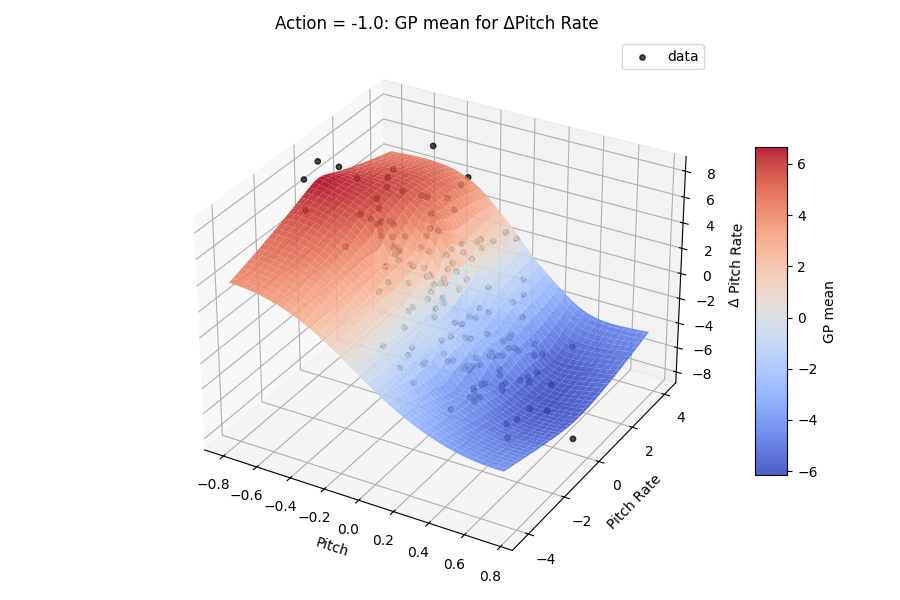

Plotting for action a=0.0
Values near action a=0.0 n=299


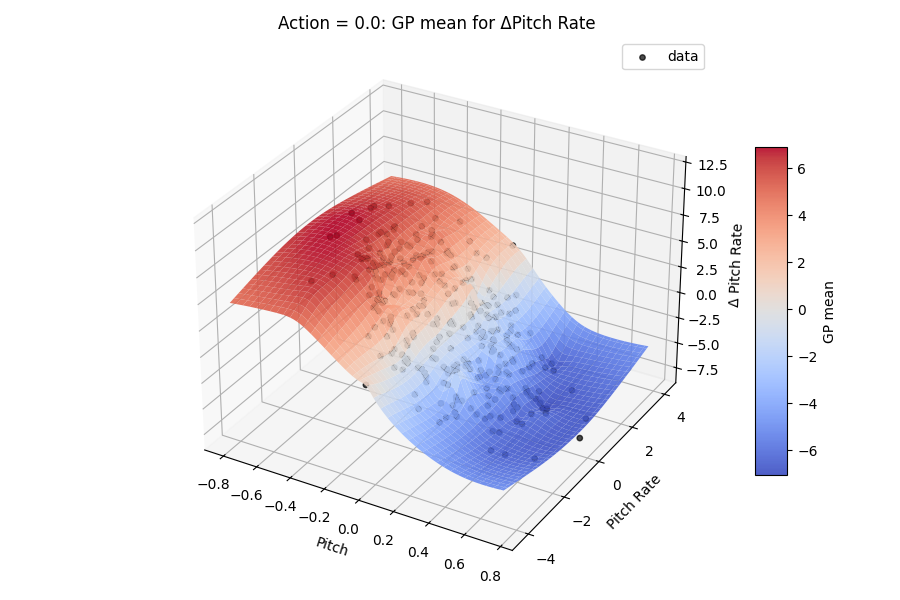

Plotting for action a=1.0
Values near action a=1.0 n=147


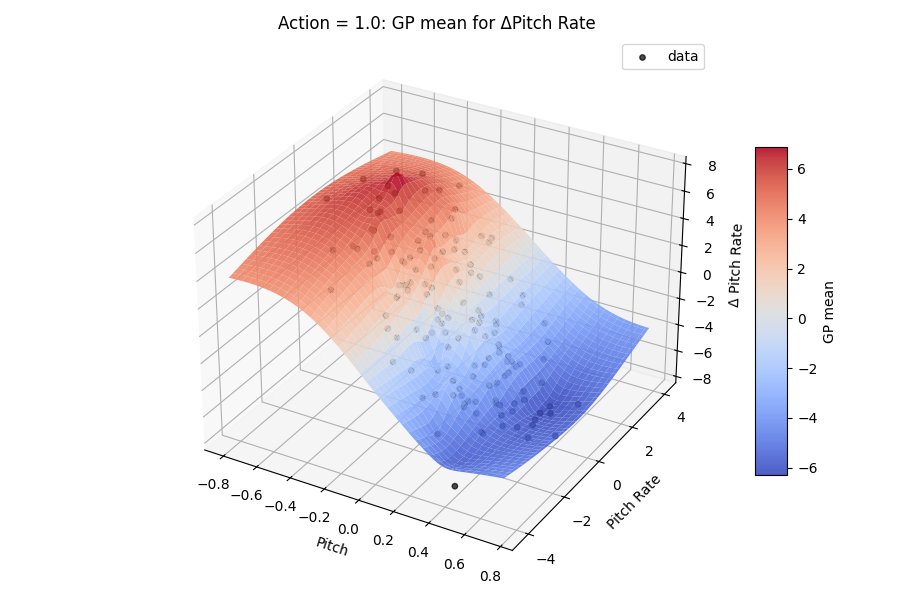

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# --------------------------------------------------------
# Visualization setup
# --------------------------------------------------------
gp = gps[1]   # e.g. GP for Δpitch_rate (or whatever output[1] is)
a_values = [-1.0, 0.0, 1.0]  # representative actions

# Get raw training data (NumPy, via dataset())
X_train, Y_train = gp.dataset()
pitch, dpitch, act = X_train[:, 0], X_train[:, 1], X_train[:, 2]
ddpitch = Y_train  # targets for this GP (e.g. Δpitch_rate)

# --------------------------------------------------------
# Define grid for visualization
# --------------------------------------------------------
p_min, p_max = pitch.min(), pitch.max()
v_min, v_max = dpitch.min(), dpitch.max()

p_grid = np.linspace(p_min, p_max, 80)
v_grid = np.linspace(v_min, v_max, 80)
P, V = np.meshgrid(p_grid, v_grid)

# --------------------------------------------------------
# Generate and plot for each action
# --------------------------------------------------------
for a_fixed in a_values:
    print(f"Plotting for action a={a_fixed}")

    # Build grid inputs: [pitch, pitch_rate, action]
    X_grid = np.column_stack([
        P.ravel(),                 # pitch
        V.ravel(),                 # pitch_rate
        np.full_like(P.ravel(), a_fixed)  # fixed action
    ])

    # --- Use NumPy-friendly predict for visualization ---
    Mean, var = gp.predict_torch(X_grid)          # Mean: (N_points,)
    Mean = Mean.detach().cpu().numpy().reshape(P.shape)            # reshape to grid

    # --------------------------------------------------------
    # Plot as surface
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(P, V, Mean, cmap='coolwarm',
                           linewidth=0, antialiased=True, alpha=0.9)

    # Overlay training data close to this action value
    mask = np.abs(act - a_fixed) < 0.5
    print(f"Values near action a={a_fixed} n={np.sum(mask)}")
    ax.scatter(
        pitch[mask], dpitch[mask], ddpitch[mask],
        color='k', s=15, alpha=0.7, label='data'
    )

    # --------------------------------------------------------
    # Labels and title
    ax.set_xlabel('Pitch')
    ax.set_ylabel('Pitch Rate')
    ax.set_zlabel('Δ Pitch Rate')
    ax.set_title(f"Action = {a_fixed:.1f}: GP mean for ΔPitch Rate")

    fig.colorbar(surf, ax=ax, shrink=0.6, aspect=10, label='GP mean')
    ax.legend()
    plt.tight_layout()
    plt.show()


Values near action a=1.0 → n=147


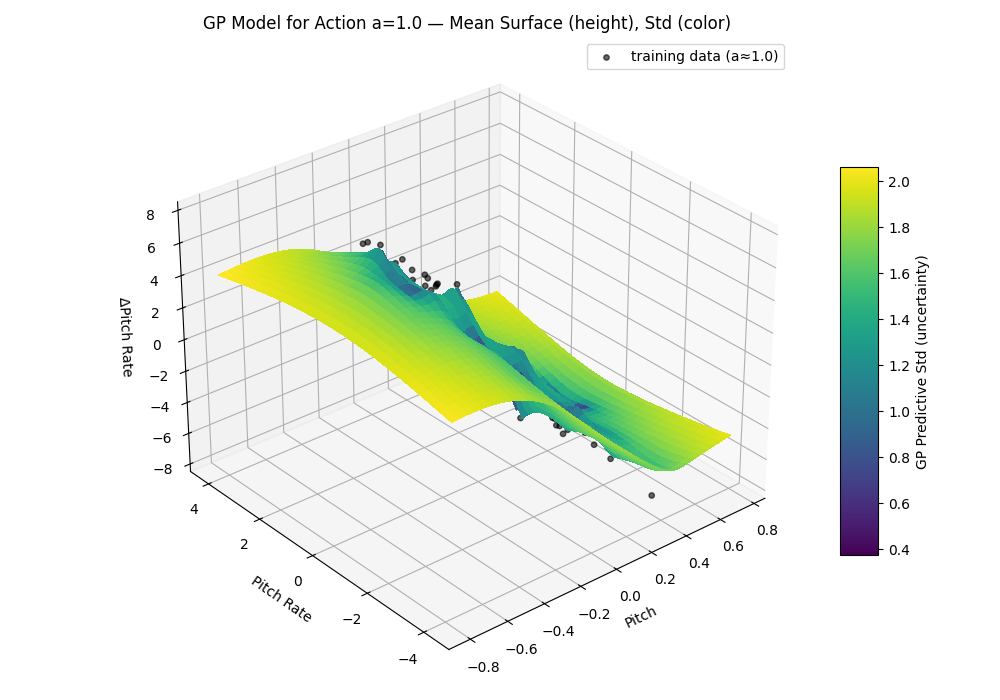

In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# --------------------------------------------------------
# Choose which GP to visualize
# --------------------------------------------------------
gp = gps[1]   # e.g. GP for Δpitch_rate (index 0 would be Δpitch)
a_fixed = 1.0 # fixed continuous action (maximum thrust)

# --------------------------------------------------------
# Get training data (NumPy from dataset())
# --------------------------------------------------------
X_train, Y_train = gp.dataset()
pitch, pitch_rate, act = X_train[:, 0], X_train[:, 1], X_train[:, 2]
d_pitch_rate = Y_train  # targets for this GP

# Select samples close to a = a_fixed for overlay
mask = np.abs(act - a_fixed) < 0.5
print(f"Values near action a={a_fixed} → n={np.sum(mask)}")

# --------------------------------------------------------
# Define pitch–pitch_rate grid
# --------------------------------------------------------
p_min, p_max = pitch.min(), pitch.max()
v_min, v_max = pitch_rate.min(), pitch_rate.max()

p_grid = np.linspace(p_min, p_max, 80)
v_grid = np.linspace(v_min, v_max, 80)
P, V = np.meshgrid(p_grid, v_grid)

# Query points for the fixed action: [pitch, pitch_rate, a_fixed]
X_grid = np.column_stack([
    P.ravel(),                     # pitch
    V.ravel(),                     # pitch_rate
    np.full_like(P.ravel(), a_fixed)  # fixed action
])

# --------------------------------------------------------
# GP predictions (torch -> numpy)
# --------------------------------------------------------
Mean_t, Var_t = gp.predict_torch(X_grid)   # torch tensors on GPU

# move to CPU and numpy for plotting
Mean = Mean_t.detach().cpu().numpy().reshape(P.shape)
Var  = Var_t.detach().cpu().numpy().reshape(P.shape)
Std  = np.sqrt(Var)

# Normalize Std for color mapping
norm = plt.Normalize(vmin=Std.min(), vmax=Std.max())
colors = plt.cm.viridis(norm(Std))

# --------------------------------------------------------
# Plot surface: Mean as height, Std as color
# --------------------------------------------------------
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    P, V, Mean,
    facecolors=colors,
    linewidth=0, antialiased=False, shade=False
)

# Colorbar = predictive uncertainty
m = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
m.set_array(Std)
cbar = fig.colorbar(m, ax=ax, shrink=0.6, aspect=10)
cbar.set_label('GP Predictive Std (uncertainty)')

# Overlay raw data (samples with similar a)
ax.scatter(
    pitch[mask], pitch_rate[mask], d_pitch_rate[mask],
    color='k', s=15, alpha=0.6, label=f'training data (a≈{a_fixed})'
)

# --------------------------------------------------------
# Labels and title
# --------------------------------------------------------
ax.set_xlabel('Pitch')
ax.set_ylabel('Pitch Rate')
ax.set_zlabel('ΔPitch Rate')
ax.set_title(f"GP Model for Action a={a_fixed:.1f} — Mean Surface (height), Std (color)")
ax.view_init(elev=30, azim=230)
ax.legend()
plt.tight_layout()
plt.show()


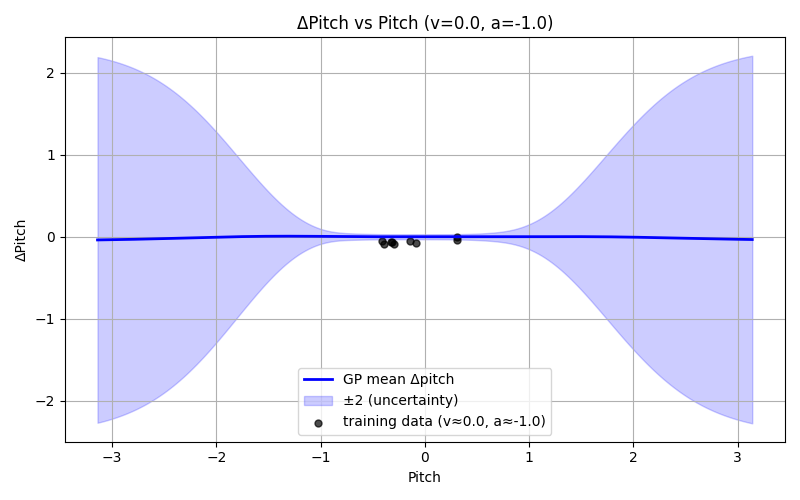

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------
# Choose GP: Δpitch model
# --------------------------------------------------------
gp = gps[0]       # GP for Δpitch (index 1 would be Δpitch_rate)
v_fixed = 0.0     # fix pitch_rate
a_fixed = -1.0    # fix action

# --------------------------------------------------------
# Define pitch grid
# --------------------------------------------------------
p_min, p_max = -3.14, 3.14
p_grid = np.linspace(p_min, p_max, 200)

# Construct query points [pitch, v_fixed, a_fixed]
X_query = np.column_stack([
    p_grid,
    np.full_like(p_grid, v_fixed),
    np.full_like(p_grid, a_fixed)
])

# --------------------------------------------------------
# Predict GP mean and std (torch -> numpy)
# --------------------------------------------------------
Mean_t, Var_t = gp.predict_torch(X_query)   # torch tensors on GPU
Mean = Mean_t.detach().cpu().numpy()
Var  = Var_t.detach().cpu().numpy()
Std  = np.sqrt(Var)

# --------------------------------------------------------
# Plot mean ± std as shaded region
# --------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(p_grid, Mean, 'b-', lw=2, label='GP mean Δpitch')
plt.fill_between(
    p_grid,
    Mean - 2 * Std,
    Mean + 2 * Std,
    color='blue',
    alpha=0.2,
    label='±2 (uncertainty)'
)

# --------------------------------------------------------
# Overlay training data near v=v_fixed and a=a_fixed
# --------------------------------------------------------
X_train, Y_train = gp.dataset()
mask = (np.abs(X_train[:, 1] - v_fixed) < 0.1) & (np.abs(X_train[:, 2] - a_fixed) < 0.5)

plt.scatter(
    X_train[mask, 0],   # pitch
    Y_train[mask],      # Δpitch
    color='k', s=25, alpha=0.7,
    label=f'training data (v≈{v_fixed}, a≈{a_fixed})'
)

# --------------------------------------------------------
# Labels and title
# --------------------------------------------------------
plt.xlabel("Pitch")
plt.ylabel("ΔPitch")
plt.title(f"ΔPitch vs Pitch (v={v_fixed}, a={a_fixed})")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# MPPI CONTROLLER

#### GP step for the MuJoCo car (using your learned GP)

In [9]:
import numpy as np

# --------------------------------------------------------------
# MPPI parameters (tune these)
# --------------------------------------------------------------
H       = 80            # prediction horizon (in model steps, e.g. ~6 s if CTRL_DT=0.1)
K       = 2000           # number of sampled trajectories
LAMBDA  = 1.0           # temperature
SIGMA   = 0.6           # std dev of exploration noise
rng     = np.random.default_rng(0)

# Action bounds from your MuJoCo controller
act_low  = U_MIN    # e.g. -1.0
act_high = U_MAX    # e.g. +1.0

# --------------------------------------------------------------
# GP-based one-step model for the car
#   state = [pitch, pitch_rate]
#   action = throttle
#   gps[0] => Δpitch, gps[1] => Δpitch_rate
# --------------------------------------------------------------
def gp_step_batch_torch(states, actions):
    """
    states : (K, 2) torch.FloatTensor on device
    actions: (K,)   torch.FloatTensor on device
    returns next_states: (K, 2) torch.FloatTensor on device
    """
    # stack to [pitch, pitch_rate, action]
    X = torch.stack([states[:, 0], states[:, 1], actions], dim=-1)

    d_pitch_mean, _ = gps[0].predict_torch(X)
    d_rate_mean,  _ = gps[1].predict_torch(X)

    next_states = torch.empty_like(states)
    next_states[:, 0] = states[:, 0] + d_pitch_mean
    next_states[:, 1] = states[:, 1] + d_rate_mean

    next_states[:, 0].clamp_(-np.pi, np.pi)
    next_states[:, 1].clamp_(-20.0, 20.0)

    return next_states



#### COST FUNCTION

In [10]:
import torch

device = torch.device("cuda")
pitch_target_t = torch.tensor(3.0, dtype=torch.float32, device=device)

def stage_cost_torch(states, actions):
    """
    states : (K, 2) torch.float32 on device  -> [pitch, pitch_rate]
    actions: (K,)   torch.float32 on device  -> throttle
    returns: (K,)   torch.float32 cost
    """
    pitch = states[:, 0]
    rate  = states[:, 1]
    u     = actions

    err = pitch - pitch_target_t

    cost_pitch = 10.0 * err**2
    cost_rate  = 0.5  * rate**2
    cost_u     = 0.1  * u**2

    return cost_pitch + cost_rate + cost_u


#### MPPI ACTION

In [11]:
@torch.no_grad()
def mppi_action_torch(x0, u_init=None):
    """
    x0     : current state [pitch, pitch_rate] (np or torch)
    u_init : previous MPPI plan (length H) for warm-start, or None

    returns:
      u0   : scalar action to apply now (float)
      u_new: updated plan (torch tensor length H on device)
    """
    # convert x0 to torch on device
    x0 = torch.as_tensor(x0, dtype=torch.float32, device=device)
    assert x0.shape == (2,), f"Expected x0 shape (2,), got {x0.shape}"

    # nominal control sequence on device
    if u_init is None:
        u_init = torch.zeros(H, dtype=torch.float32, device=device)
    else:
        u_init = torch.as_tensor(u_init, dtype=torch.float32, device=device)
        assert u_init.shape[0] == H

    # sample noise on GPU
    eps = torch.randn(K, H, device=device) * SIGMA
    U   = torch.clamp(u_init.unsqueeze(0) + eps, act_low, act_high)  # (K,H)

    # rollout trajectories under GP model
    states = x0.unsqueeze(0).repeat(K, 1)        # (K,2)
    costs  = torch.zeros(K, dtype=torch.float32, device=device)

    for t in range(H):
        u_t = U[:, t]                            # (K,)
        costs = costs + stage_cost_torch(states, u_t)
        states = gp_step_batch_torch(states, u_t)

    # MPPI weighting
    J_min   = costs.min()
    weights = torch.exp(-(costs - J_min) / LAMBDA)
    weights_sum = weights.sum() + 1e-8

    # Weighted update of the control sequence
    du    = (weights.unsqueeze(1) * eps).sum(dim=0) / weights_sum   # (H,)
    u_new = torch.clamp(u_init + du, act_low, act_high)             # (H,)

    # First action as Python float for MuJoCo ctrl[:]
    u0 = float(u_new[0].detach().cpu().item())

    return u0, u_new.detach()


### Run Mujoco Simulation

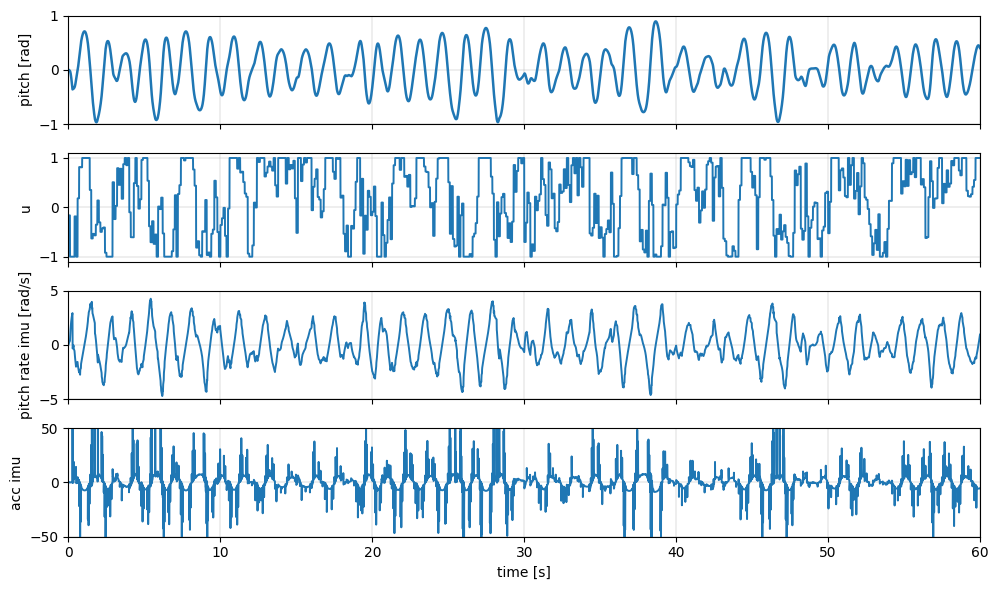

Done. Samples: 60001  Sim time: 60.001s


In [12]:
# ====== 4) MuJoCo + MPPI control loop with live plotting ======

import time, math, numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import mujoco as mj
import mujoco.viewer as viewer

# -------- config --------
CTRL_DT   = 0.1          # control update period (sim seconds)
DURATION  = 60.0         # total run time (sim seconds)
U_MIN, U_MAX = -1.0, 1.0 # throttle bounds
RTF      = 1.0           # realtime factor
REFRESH_HZ = 10           # plot refresh rate (wall-clock)

MODEL_XML = "monstertruck.xml"

# -------- model --------
m = mj.MjModel.from_xml_path(MODEL_XML)
data = mj.MjData(m)
mj.mj_resetData(m, data); mj.mj_forward(m, data)
data.ctrl[:] = 0.0

sim_dt        = float(m.opt.timestep)
steps_per_cmd = max(1, int(round(CTRL_DT / sim_dt)))
free_j = next(j for j in range(m.njnt) if m.jnt_type[j] == mj.mjtJoint.mjJNT_FREE)
qadr   = m.jnt_qposadr[free_j] + 3  # qw,qx,qy,qz start

# --- IMU gyro sensor (for pitch rate) ---
gyro_id = mj.mj_name2id(m, mj.mjtObj.mjOBJ_SENSOR, "imu_gyro")
if gyro_id < 0:
    raise RuntimeError("imu_gyro sensor not found in model XML")
gyro_adr = m.sensor_adr[gyro_id]

# --- IMU acc sensor (for logging / future features) ---
acc_id = mj.mj_name2id(m, mj.mjtObj.mjOBJ_SENSOR, "imu_acc")
if acc_id < 0:
    raise RuntimeError("imu_acc sensor not found in model XML")
acc_adr = m.sensor_adr[acc_id]

# -------- live plot setup --------
plt.ioff()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

(line_pitch,)    = ax1.plot([], [], lw=1.8)
(line_u,)        = ax2.plot([], [], lw=1.4)
(line_rate_imu,) = ax3.plot([], [], lw=1.4)
(line_acc_imu,)  = ax4.plot([], [], lw=1.4)

ax1.set_ylabel("pitch [rad]")
ax1.set_ylim(-1, 1)
ax1.grid(True, linewidth=0.3)

ax2.set_ylabel("u")
ax2.set_ylim(U_MIN - 0.1, U_MAX + 0.1)
ax2.grid(True, linewidth=0.3)

ax3.set_ylabel("pitch rate imu [rad/s]")
ax3.set_ylim(-5.0, 5.0)
ax3.grid(True, linewidth=0.3)

ax4.set_ylabel("acc imu")
ax4.set_ylim(-50.0, 50.0)
ax4.set_xlabel("time [s]")
ax4.grid(True, linewidth=0.3)

fig.tight_layout()
display(fig)

# -------- logs --------
t_log        = []
pitch_log    = []
u_log        = []
rate_imu_log = []
acc_imu_log  = []

last_refresh_wall = time.perf_counter()

# MPPI warm-start plan (length H, defined in previous cell)
plan = None

with viewer.launch_passive(m, data) as v:
    t0_sim   = data.time
    t0_wall  = time.perf_counter()
    next_cmd = t0_sim
    u = 0.0

    while data.time - t0_sim < DURATION:
        # ---- control update at CTRL_DT (sim time) ----
        if data.time >= next_cmd:
            # read current pitch from quaternion
            qw, qx, qy, qz = data.qpos[qadr:qadr+4]
            _, pitch, _ = quat_to_rpy_rad(qw, qx, qy, qz)

            # pitch rate from IMU gyro (y-axis)
            gyro = data.sensordata[gyro_adr : gyro_adr + 3]
            pitch_rate_imu = float(gyro[1])

            # current state for MPPI: [pitch, pitch_rate]
            x0 = np.array([pitch, pitch_rate_imu], dtype=np.float32)

            # get MPPI action + new plan
            u_cmd, plan = mppi_action_torch(x0, plan)
            u_cmd = float(np.clip(u_cmd, U_MIN, U_MAX))
            u = u_cmd
            data.ctrl[:] = u

            next_cmd += CTRL_DT

        # ---- one physics tick ----
        mj.mj_step(m, data)

        # read state for logging
        qw, qx, qy, qz = data.qpos[qadr:qadr+4]
        _, pitch, _ = quat_to_rpy_rad(qw, qx, qy, qz)

        gyro = data.sensordata[gyro_adr : gyro_adr + 3]
        pitch_rate_imu = float(gyro[1])

        acc = data.sensordata[acc_adr : acc_adr + 3]
        acc_imu = float(acc[0])

        t_rel = data.time - t0_sim

        t_log.append(t_rel)
        pitch_log.append(pitch)
        u_log.append(u)
        rate_imu_log.append(pitch_rate_imu)
        acc_imu_log.append(acc_imu)

        # ---- live plot at REFRESH_HZ ----
        now = time.perf_counter()
        if now - last_refresh_wall >= 1.0 / REFRESH_HZ:
            line_pitch.set_data(t_log, pitch_log)
            line_u.set_data(t_log, u_log)
            line_rate_imu.set_data(t_log, rate_imu_log)
            line_acc_imu.set_data(t_log, acc_imu_log)

            ax1.set_xlim(0.0, max(5.0, t_rel))
            clear_output(wait=True)
            display(fig)
            last_refresh_wall = now

        # ---- real-time pacing ----
        sim_elapsed  = data.time - t0_sim
        target_wall  = t0_wall + sim_elapsed / max(1e-9, RTF)
        sleep_needed = target_wall - time.perf_counter()
        if sleep_needed > 0:
            time.sleep(min(sleep_needed, 0.01))

        v.sync()

# final draw
line_pitch.set_data(t_log, pitch_log)
line_u.set_data(t_log, u_log)
line_rate_imu.set_data(t_log, rate_imu_log)
line_acc_imu.set_data(t_log, acc_imu_log)
ax1.set_xlim(0.0, max(5.0, t_log[-1] if t_log else 5.0))
clear_output(wait=True)
display(fig)

print(f"Done. Samples: {len(t_log)}  Sim time: {t_log[-1]:.3f}s")
